In [1]:
#123456789012345678901234567890123456789012345678901234567890123456789012345678

# Unsupervised: Hierarchical Clustering

This notebook attempts hierarchical clustering on different subsets of the data, using a range of hyperparameters, to discern latent structure in:

 1) the base financial data, and
 2) derived variables: a) rates of change, b) key performance indicators

In [2]:
import sys
PATH_TO_MODULES = '../../..'
sys.path.insert(0, PATH_TO_MODULES)

from helpers import *
from unsupervised_helpers import *

In [3]:
import altair as alt
from matplotlib.colors import ListedColormap

In [4]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy

In [5]:


def plot_dendrogram(model, colors, **kwargs):
    """Create linkage matrix and then plot the dendrogram.

    Taken from scikit-learn example code.
    """
    # Set colors
    hierarchy.set_link_color_palette(
        colors
    )
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    # Plot the corresponding dendrogram
    hierarchy.dendrogram(linkage_matrix, **kwargs)
    return None

    

In [6]:
# Import merged dataset
path = PATH_TO_MODULES + '/datasets/'
base = 'X_train_filled.csv'
expanded = 'X_train_filled_KPIs_QoQ_PCA.csv'
X_train_base = pd.read_csv(path + base, index_col='Ticker')
X_train_expanded = pd.read_csv(path + expanded, index_col='Ticker')
print(X_train_base.shape, X_train_expanded.shape)

(1910, 108) (1910, 325)


## Base Financial Data

In [7]:
# Select key base variables for log transformation
# Note: NetIncome and CashFromOps have too many negative values
log_vars = ['Revenue',
            #'NetIncome',
            'CurrentAssets',
            'CurrentLiabilities',
            'TotalAssets',
            'TotalLiabilities',
            'TotalEquity',
            'TotalDebt',
            #'CashFromOps'
           ]
quarters = get_quarters(X_train_base)

In [57]:
# Drop where Revenue or TotalEquity <= 0
fix_vars = ['Revenue', 'TotalEquity']
index_to_drop = set()
for var in fix_vars:
    for quarter in quarters:
        mask = X_train_base[var + quarter] <= 0
        for index in X_train_base[var + quarter][mask].index:
            index_to_drop.add(index)
X_train_base.drop(index=index_to_drop, inplace=True)
print(X_train_base.shape)

(1821, 108)


In [9]:
# Make DataFrame for clustering
log_cluster_df = pd.DataFrame()
for var in log_vars:
    for quarter in quarters:
        log_cluster_df[var + quarter] = (
            X_train_base[var + quarter] + 2
        ).apply(np.log2)
print(log_cluster_df.shape)

(1821, 28)


In [11]:
glom = AgglomerativeClustering(
    n_clusters=n_clusters,
    metric='euclidean',
    linkage='ward',
    distance_threshold=None,
    compute_distances=True,
    memory='cache/'
)

In [12]:
y = glom.fit_predict(log_cluster_df)
np.unique_counts(y)

UniqueCountsResult(values=array([0, 1, 2, 3, 4, 5, 6]), counts=array([301, 438, 228, 218, 331, 270,  35]))

In [49]:
# Set custom colors for each cluster
colors = ['green', 'blue', 'gray', 'purple', 'darkred', 'red', 'orange',
          'darkgreen', 'darkblue', 'darkgray', 'lightgreen', 'lightblue'
         ]
cmap = ListedColormap(colors)

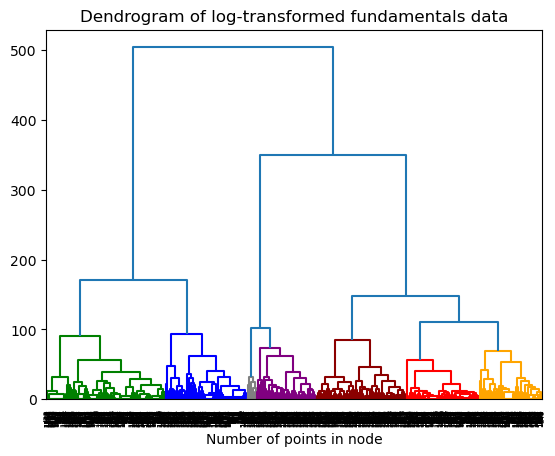

In [14]:
plt.title('Dendrogram of log-transformed fundamentals data')
plot_dendrogram(
    model=glom,
    colors=colors,
    color_threshold=100
)
plt.show()

### Visualize clusters using MDS

In [15]:
# MDS using default parameters
mds = MDS(n_init=1)
X_MDS = mds.fit_transform(log_cluster_df)

In [56]:
# Map Market Cap to size of the point displayed in the plot
# Color indicates label assigned by agglomerative clustering
size_map = {
    'Micro-Cap': 1,
    'Small-Cap': 3,
    'Mid-Cap': 12,
    'Large-Cap': 36,
    'Mega-Cap': 108
}
size = pd.Series(X_train_base['Market Cap'].map(size_map), name='Size')

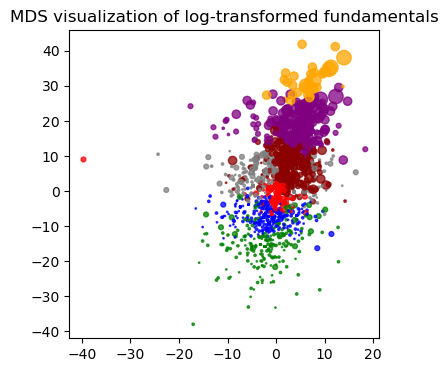

In [17]:
fig = plt.figure(figsize=(4, 4))
ax = fig.subplots()
ax.scatter(X_MDS[:, 0], X_MDS[:, 1], s=size, c=y, cmap=cmap, alpha=0.75)
ax.set_title('MDS visualization of log-transformed fundamentals')
ax.legend(y)
plt.show()

In [47]:
X_train_base['Sector'].unique()

array(['Information Technology', 'Financials', 'Health Care',
       'Industrials', 'Consumer Discretionary', 'Energy', 'Materials',
       'Utilities', 'Real Estate', 'Communication', 'Consumer Staples'],
      dtype=object)

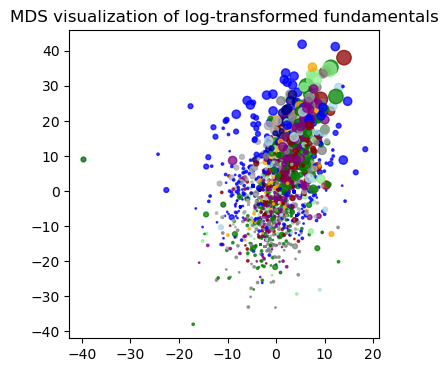

In [55]:
# Show sector as color
sectors = X_train_base['Sector'].unique()
"""sector_map = {
    0: 'Information Technology',
    1'Financials',
    'Health Care',
    'Industrials',
    'Consumer Discretionary',
    'Energy',
    'Materials',
    'Utilities',
    'Real Estate',
    'Communication',
    'Consumer Staples'
}
"""
sector_map = {sector: label for sector, label in zip(
    sectors, range(len(sectors))
)
             }
sector = list(X_train_base['Sector'].map(sector_map))
fig = plt.figure(figsize=(4, 4))
ax = fig.subplots()
ax.scatter(X_MDS[:, 0], X_MDS[:, 1], s=size, c=sector, cmap=cmap, alpha=0.75)
ax.set_title('MDS visualization of log-transformed fundamentals')
ax.legend(sector)
plt.show()

In [51]:
sector_map

{0: 'Information Technology',
 1: 'Financials',
 2: 'Health Care',
 3: 'Industrials',
 4: 'Consumer Discretionary',
 5: 'Energy',
 6: 'Materials',
 7: 'Utilities',
 8: 'Real Estate',
 9: 'Communication',
 10: 'Consumer Staples'}

## Rates of change (QoQ, etc.)

In [29]:
rate_df = get_Rate(X_train_expanded)
"""
macro_vars=['GDP_',
            'GDPReal_',
            'Unemployment',
            'InterestRate',
            'Industrial',
            'Inflation'
            ]
cols_to_drop = []
for column in rate_df.columns:
    for var in macro_vars:
        if var in column:
            cols_to_drop.append(column)
rate_df.drop(columns=cols_to_drop, inplace=True)
""";

In [42]:
n_clusters=12
glom = AgglomerativeClustering(
    n_clusters=n_clusters,
    metric='euclidean',
    linkage='ward',
    distance_threshold=None,
    compute_distances=True,
    memory='cache/'
)

In [37]:
y = glom.fit_predict(rate_df)
np.unique_counts(y)

UniqueCountsResult(values=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), counts=array([   8,   85,   23,    3,   35, 1661,    1,    1,    1,    1,    1,
          1]))

Rate of change data does not appear to be useful for clustering: the vast majority of companies (1661) are assigned to a single cluster.  Extreme outliers could be the problem.

In [45]:
rate_df.describe()

,OperatingIncome_QoQ_24Q2_24Q3,OperatingIncome_QoQ_24Q3_24Q4,OperatingIncome_QoQ_24Q4_25Q1,TotalAssets_QoQ_24Q2_24Q3,TotalAssets_QoQ_24Q3_24Q4,TotalAssets_QoQ_24Q4_25Q1,TotalDebt_QoQ_24Q2_24Q3,TotalDebt_QoQ_24Q3_24Q4,TotalDebt_QoQ_24Q4_25Q1,CapitalExpenditure_QoQ_24Q2_24Q3,...,EPS_Rate,TotalLiabilities_Rate,CurrentLiabilities_Rate,NetIncome_Rate,InterestExpense_Rate,CurrentAssets_Rate,LongTermDebt_Rate,TotalEquity_Rate,Revenue_Rate,IncomeTaxExpense_Rate
count,1821.000000,1821.000000,1821.000000,1821.000000,1821.000000,1821.000000,1821.000000,1821.000000,1821.000000,1821.000000,...,1821.000000,1.821000e+03,1.821000e+03,1.821000e+03,1.821000e+03,1.821000e+03,1.821000e+03,1.821000e+03,1.821000e+03,1.821000e+03
mean,-0.021775,1.698931,-0.072786,0.611920,0.020343,0.013534,0.608290,0.664361,1.486564,1.003763,...,-0.002455,1.396091e+08,2.561817e+06,7.322834e+06,-6.763378e+06,1.526728e+07,6.460028e+07,1.487442e+08,5.467868e+07,-2.172474e+06
std,1.765210,33.465292,11.571210,23.437102,0.107429,0.092127,19.899252,15.896509,34.245137,52.554852,...,0.746808,3.902330e+09,2.949811e+09,1.917949e+08,2.258961e+08,2.859540e+09,1.167264e+09,1.202394e+09,1.452899e+09,6.570535e+07
min,-32.663338,-45.217377,-408.201320,-0.898362,-0.922419,-0.535734,-0.999278,-0.999930,-0.994687,-1000.000000,...,-6.815000,-1.071542e+11,-1.071908e+11,-4.163600e+09,-6.416100e+09,-1.064611e+11,-2.331980e+10,-4.189500e+09,-2.116010e+10,-1.685700e+09
25%,-0.157918,-0.223829,-0.274510,-0.002668,-0.014564,-0.017254,-0.036418,-0.033542,-0.048594,-0.209068,...,-0.067000,-1.802075e+07,-7.700000e+06,-5.966500e+06,-9.043000e+05,-1.079000e+07,-8.431100e+06,-2.238900e+06,-5.903000e+06,-1.757700e+06
50%,0.004884,0.000000,-0.096807,0.017656,0.011249,0.009165,-0.003179,-0.002397,-0.001372,0.012658,...,-0.003000,1.254000e+07,4.418700e+06,-1.096800e+06,-2.600000e+03,7.415600e+06,-9.320000e+04,1.731235e+07,2.076500e+06,-2.993000e+05
75%,0.163661,0.177676,0.153131,0.052480,0.036097,0.026952,0.019172,0.041781,0.022475,0.221487,...,0.059000,1.188964e+08,2.502195e+07,2.926600e+06,4.492000e+05,3.046320e+07,2.944720e+07,6.411360e+07,1.378360e+07,4.167789e+05
max,15.079450,1000.000000,206.694158,1000.000000,1.658935,2.412221,843.866385,537.649123,1000.000000,1000.000000,...,18.674000,4.117810e+10,2.737040e+10,3.299800e+09,3.159000e+09,2.309550e+10,2.543691e+10,2.791700e+10,5.260840e+10,1.025300e+09


We can that the interquartile range for most derived rate variables is very narrow compared to the min/max values.  This signals the presence of extreme outliers.

One possibility: When we imputed data, we created relationships between base variables that made no sense.  This resulted in extreme outliers in derived features.

## Key performance indicators

In [40]:
KPI_df = get_KPI(X_train_expanded)
cols_to_drop = []
for column in KPI_df:
    if 'PCA' in column:
        cols_to_drop.append(column)
KPI_df.drop(columns=cols_to_drop, inplace=True)
KPI_df

In [42]:
n_clusters=7
glom = AgglomerativeClustering(
    n_clusters=n_clusters,
    metric='euclidean',
    linkage='ward',
    distance_threshold=None,
    compute_distances=True,
    memory='cache/'
)

In [43]:
y = glom.fit_predict(KPI_df)
np.unique_counts(y)

UniqueCountsResult(values=array([0, 1, 2, 3, 4, 5, 6]), counts=array([   2,    1, 1814,    1,    1,    1,    1]))

Similarly for the KPIs: they do not appear to be useful for clustering.

In [44]:
KPI_df.describe()

,KPI_GrossProfitMargin_2024Q2,KPI_GrossProfitMargin_2024Q3,KPI_GrossProfitMargin_2024Q4,KPI_GrossProfitMargin_2025Q1,KPI_NetProfitMargin_2024Q2,KPI_NetProfitMargin_2024Q3,KPI_NetProfitMargin_2024Q4,KPI_NetProfitMargin_2025Q1,KPI_CurrentRatio_2024Q2,KPI_CurrentRatio_2024Q3,...,KPI_ReturnOnAssets_2024Q4,KPI_ReturnOnAssets_2025Q1,KPI_NetProfitMargin_Rate,KPI_ReturnOnAssets_Rate,KPI_ReturnOnEquity_Rate,KPI_CurrentRatio_Rate,KPI_DebtToEquityRatio_Rate,KPI_TotalAssetTurnover_Rate,KPI_GrossProfitMargin_Rate,KPI_Leverage_Rate
count,1821.000000,1821.000000,1821.000000,1821.000000,1821.000000,1821.000000,1821.000000,1821.000000,1821.000000,1821.000000,...,1821.000000,1821.000000,1821.000000,1821.000000,1821.000000,1821.000000,1821.000000,1821.000000,1821.000000,1821.000000
mean,0.395048,0.390074,0.386465,0.388230,-0.321397,-0.136287,-0.531317,0.087075,3.227540,2.852077,...,0.005523,0.005267,0.083039,-0.000695,-0.003159,0.674799,-52.226180,-0.002466,-0.002407,-0.038691
std,0.268747,0.276155,0.289558,0.261276,8.028191,5.044650,19.466381,10.621051,16.993486,9.737204,...,0.035014,0.027191,2.832102,0.016739,0.052289,23.232398,2228.218383,0.022484,0.036585,1.459172
min,-2.088953,-1.961560,-3.893945,-0.972193,-322.294077,-156.314545,-826.403226,-77.404317,0.000113,0.000085,...,-0.444825,-0.272241,-21.604647,-0.397319,-0.928095,-175.426647,-95085.156929,-0.252466,-0.487656,-34.764055
25%,0.224436,0.168167,0.186940,0.203223,0.022091,0.012031,0.008987,0.006056,1.231548,1.212599,...,0.001294,0.000520,-0.012673,-0.002378,-0.006174,-0.082511,-0.032258,-0.007352,-0.008951,-0.083558
50%,0.391321,0.380787,0.374292,0.375549,0.067514,0.058834,0.054616,0.043505,1.951950,1.862187,...,0.006355,0.004618,-0.003735,-0.000574,-0.001823,-0.013290,-0.006299,-0.000768,-0.000376,-0.012235
75%,0.599436,0.630468,0.595539,0.595910,0.152392,0.157101,0.161258,0.150602,2.717920,2.492389,...,0.014830,0.012626,0.012477,0.001117,0.002850,0.093391,0.019668,0.002569,0.003813,0.036602
max,1.000000,1.119794,1.579463,1.557851,11.927034,105.746876,18.782546,435.435897,585.500000,305.145000,...,0.418274,0.332759,96.312339,0.210351,0.468379,828.427885,12.059658,0.225583,0.678142,23.353641


We see a similar trend in many of the KPIs:  extreme outliers that may be throwing off the ability of the algorithm to cluster the data.